In [11]:
# %pip install graphviz
# import os
# dot_path = r"C:\Program Files\Graphviz\bin\dot.exe"
# if not os.path.exists(dot_path):
    # raise FileNotFoundError("未找到 Graphviz dot 可执行文件，请安装到 C\\Program Files\\Graphviz\\bin\\dot.exe 或更新路径。")
# os.environ["GRAPHVIZ_DOT"] = dot_path
# os.environ["PATH"] = os.path.dirname(dot_path) + os.pathsep + os.environ.get("PATH", "")
# from graphviz import backend
# backend.dot_command = os.environ["GRAPHVIZ_DOT"]

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

In [2]:
def combine_binary_labels(method):#decorator to combine labels in binary operations
  def wrapper(self, other, *args, **kwargs):
    out = method(self, other, *args, **kwargs)
    other_val = other
    # #method是被装饰的二元操作方法
    # other_val = other if hasattr(other, 'label') else None
    # #other_val用于存储另一个操作数的标签, hasattr(other, 'label')检查other是否有'label'属性
    # if other_val is None and hasattr(out, '_prev'):
    #   #如果other没有标签,则从输出值的前驱节点中寻找另一个操作数
    #   for p in out._prev:
    #     if p is not self:
    #       other_val = p
    #       break
    #     #找到另一个操作数后跳出循环
    if getattr(self, 'label', '') and getattr(other_val, 'label', ''):
      #首先保证两个操作数都有标签，getattr用于获取对象属性，若属性不存在则返回默认值''
      if not getattr(out, 'label', ''):
        #确保输出值一开始没有标签
        out.label = f"{self.label}{other_val.label}"
    return out
  return wrapper

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label
        
  def __repr__(self):#fallback string representation
    return f"Value(data={self.data})"
  
  @combine_binary_labels
  def __add__(self, other):#overload + operator
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  @combine_binary_labels
  def __mul__(self, other): #overload * operator
    other = other if  isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __rmul__(self, other):  #right-side multiplication
    return self * other
  
  @combine_binary_labels
  def __pow__(self, other): #overload ** operator
    out = Value(self.data**other, (self, ), f'**{other}')
    
    def _backward():
      self.grad += other * (self.data**(other -1)) * out.grad
    out._backward = _backward
    
    return out
  def __neg__(self):  #overload unary - operator
    return self * Value(-1.0)
  
  def __sub__(self, other):   #overload - operator
    return self + (-other)
  
  def __truediv__(self, other):   #overload / operator
    return self * other**-1
  
  def exp(self):    #exponential function   
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward(): 
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  def log(self):  #natural logarithm
    x = self.data
    out = Value(math.log(x), (self, ), 'log')
    
    def _backward():
      self.grad += (1/x) * out.grad
    out._backward = _backward
    
    return out

  def tanh(self):   #hyperbolic tangent function
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self): #backpropagation
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()




$\tanh(x)=\frac{e^{2x}-1}{e^{2x}+1}$

In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [4]:
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')
b=Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; #x1w1.label='x1w1'
x2w2 = x2 * w2; #x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; #x1w1x2w2.label='x1w1x2w2'
y=x1w1x2w2 + b; #y.label='y'
o=((2*y).exp()-1)/((2*y).exp()+1); #o.label='o'

In [24]:
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')
b=Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
y=x1w1x2w2 + b; y.label='y'
oh=y.tanh(); oh.label='oh'
t=0

In [ ]:
## getattr 案例，注意getattr中的第三个参数''
if getattr(t, 'label',''):
    print("x1 has label:", t.label)
else:
    print("t has no label")

t has no label


In [5]:
o.backward()

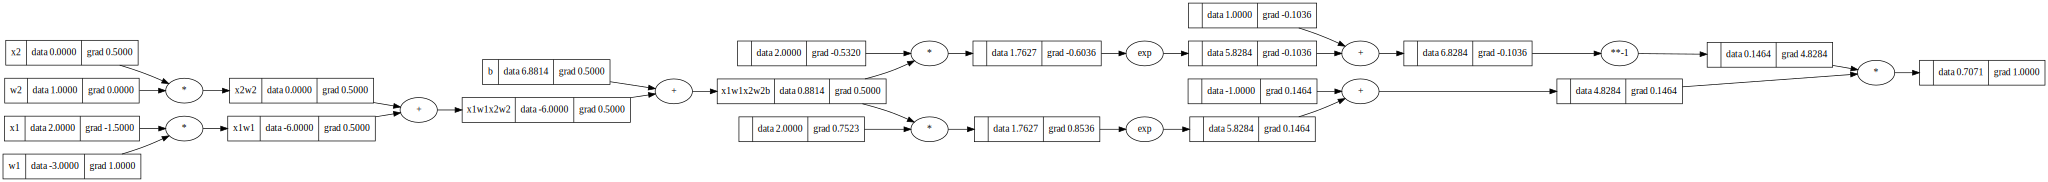

In [6]:
draw_dot(o)

In [10]:
oh.backward()

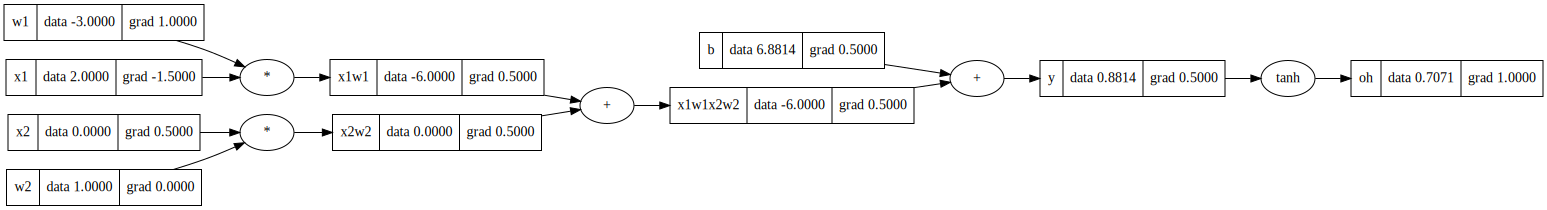

In [11]:
draw_dot(oh)

映射关系的内部延拓不影响原有梯度反向传播结果

In [10]:
%pip install torch


   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/110.9 MB 1.7 MB/s eta 0:01:06
   ---------------------------------------- 1.0/110.9 MB 1.9 MB/s eta 0:01:00
    --------------------------------------- 1.8/110.9 MB 2.4 MB/s eta 0:00:46
   - -------------------------------------- 2.9/110.9 MB 2.9 MB/s eta 0:00:37
   - -------------------------------------- 4.7/110.9 MB 4.0 MB/s eta 0:00:27
   - -------------------------------------- 5.2/110.9 MB 4.2 MB/s eta 0:00:25
   - -------------------------------------- 5.2/110.9 MB 4.2 MB/s eta 0:00:25
   - -------------------------------------- 5.2/110.9 MB 4.2 MB/s eta 0:00:25
   - ----------------

In [11]:
import torch

In [14]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad_(True)
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad_(True)
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad_(True)
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad_(True)
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad_(True)
n = w1*x1 + w2*x2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [15]:
torch.Tensor([[1,2,3],[4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [16]:
torch.Tensor([[1,2,3],[4,5,6]]).shape

torch.Size([2, 3])

In [17]:
torch.Tensor([2.0]).double()

tensor([2.], dtype=torch.float64)

In [20]:
o.item()

0.7071066904050358

神经网络基本认识[networkDefinition]，我们首先按照下图定义神经元

[networkDefinition]: https://www.cs.toronto.edu/~lczhang/aps360_20191/lec/w02/terms.html

![基本神经元数学结构](neuron_model.jpeg "基本神经元数学结构")

In [11]:
# 下标装饰器函数：将数字转换为Unicode下标字符
def subscript(n):
    """将数字转换为下标形式，供所有类和函数使用"""
    digits = "₀₁₂₃₄₅₆₇₈₉"
    return "".join(digits[int(ch)] for ch in str(n))

In [12]:
class Neuron:
    def __init__(self, nin, layer_idx=1, neuron_idx=1):
        # 使用下标风格的参数标签 w_{层,神经元,输入} 和 b_{层,神经元}
        self.layer_idx = layer_idx
        self.neuron_idx = neuron_idx
        self.w = [Value(np.random.uniform(-1, 1), label=f"w{subscript(self.layer_idx)}{subscript(self.neuron_idx)}{subscript(i+1)}") for i in range(nin)]#[]用于收集成为列表，作为神经元输入的权重
        self.b = Value(np.random.uniform(-1, 1), label=f"b{subscript(self.layer_idx)}{subscript(self.neuron_idx)}")#偏置用于控制神经元整体的触发频率
        
    def __call__(self, x):
        #n=n(x)=n.__call__(x)=w*x+b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)#self.b作为sum的初始值,可以增加计算效率
        #wi*xi for wi, xi in zip(self.w, x)作为生成器表达式，在python中必须用括号包裹
        out = act.tanh()
        out.label = f"n{subscript(self.layer_idx)}{subscript(self.neuron_idx)}"
        return out
    
    def parameters(self):
        #收集Neuron参数，输出向量格式
        return self.w + [self.b]
    

In [13]:
x=[2.0, 3.0]
n=Neuron(2)
n(x)

Value(data=-0.9752283164181957)

In [14]:
##zip 可以将迭代器整合
print(list(zip([1,2,3], [5,6])))

[(1, 5), (2, 6)]


In [15]:
print(list(zip([1,2,3], [4,5,6])))

[(1, 4), (2, 5), (3, 6)]


In [16]:
print(list(zip([1,2,3], [4,5,6], [7,8,9])))

[(1, 4, 7), (2, 5, 8), (3, 6, 9)]


接下来定义神经层

![基本神经层图连接结构](neuron_Layel.jpg "基本神经层图连接结构")

层结构是独立的神经元的集合

In [13]:
class Layer:
    def __init__(self, nin, nout, layer_idx=1):
        #初始化层内的每一个独立神经元，根据Neuron的定义，初始参数都是随机的
        self.layer_idx = layer_idx
        self.neurons = [Neuron(nin, layer_idx=self.layer_idx, neuron_idx=i+1) for i in range(nout)]

    def __call__(self, x):
        #调用层时，将输入传递给层内的每个神经元（全连接），收集它们的输出
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


In [ ]:
n=Layer(2,4)
n(x)

接下来将不同层连接起来，组建多层感知器（MLP）

In [19]:
[3]+[1,2,3]

[3, 1, 2, 3]

In [14]:
class MLP:
    def __init__(self, nin, nouts):
        ##这里的nouts是所有Layer中的nout构成的向量。nin是初始层接受的输入向量维度
        ##后续层接受的输入层维度由上一层的nout决定，因此设计sz和Layer(sz[i],sz[i+1])
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1], layer_idx=i+1) for i in range(len(nouts))]
    def __call__(self,x):
        #输入向量在不同层迭代更新
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for Layer in self.layers for p in Layer.parameters()]


In [15]:
T = MLP(3,[4,4,1])
o=[Value(1), Value(2), Value(3)]
T(o)
print(len(T.parameters()))
T.parameters()

41


[Value(data=0.674936046513841),
 Value(data=-0.6020350959681511),
 Value(data=-0.3380848234597591),
 Value(data=-0.9280292705927111),
 Value(data=0.7431897216719854),
 Value(data=0.6276672385078634),
 Value(data=-0.7953993941937625),
 Value(data=0.7426774345361338),
 Value(data=-0.3414756428988128),
 Value(data=-0.56984068672152),
 Value(data=0.6342807751563098),
 Value(data=0.5836554080330156),
 Value(data=0.5423885082884079),
 Value(data=-0.19886464030023165),
 Value(data=0.14596341281620862),
 Value(data=0.6312706669677244),
 Value(data=-0.6728791211833294),
 Value(data=0.10746592409252287),
 Value(data=0.6127050154478602),
 Value(data=0.06682813173601465),
 Value(data=0.012678207086790794),
 Value(data=-0.5547998970213208),
 Value(data=-0.7144842368057396),
 Value(data=-0.9238038563926716),
 Value(data=0.7648764125678713),
 Value(data=0.17248642265157255),
 Value(data=0.9112460315273017),
 Value(data=-0.18994477817425737),
 Value(data=-0.10203958098199006),
 Value(data=0.0731140243

In [ ]:
T(o).backward()
draw_dot(T(o))

##注意，这种写法会导致梯度被覆盖，画的图会不对，这是因为，
##T(o).backward()和draw_dot(T(o))本质上是两个T(o)，虽然T的参数没有发生改变(o的输入只调用了T的__call__,没激活初始化，因而没有wi和bi的随机化)
##但是,由于迭代调用__call__,最终会调用到act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)，这里的x就是输入的o
##对于内部的Value类算子来说，xi相当于一个新的输入，因此得到wi*xi是一个新的初始化的Value，其grad为0，第一步的T(o).backward()并没有更新这部分的梯度
##之所以看到部分draw_dot(T(o))部分Value的grad不为0，是因为原有的+self.b并没有重新初始化，因此对应的节点位置grad不为0

In [ ]:
#draw_dot(T(o).backward())
##这种调用方式也是错误的，T(o).backward()本身是执行所有向前传播过程的，没有返回值

In [24]:
# 重要：保存前向传播的输出结果
# 每次调用T(o)都会创建新的计算图（新的Value对象），虽然网络参数相同
# 为了正确进行反向传播和可视化，必须保存并使用同一个输出对象
result = T(o)
result.backward()

In [25]:
result.grad

1.0

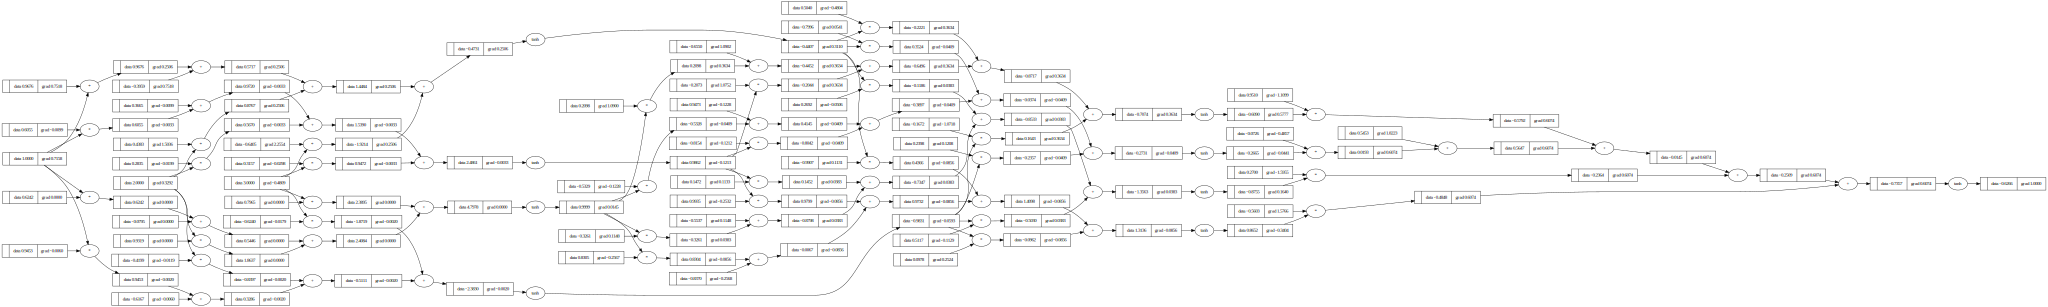

In [26]:
draw_dot(result)

基于以上随机生成的网络，接下来给出我们希望的输入和输出，看看网络的效果

In [16]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]##这是期望输出，看得出来是一个二分类问题

## Value化xs和ys，并增加label,例如x₁₁和y₁（使用下标）
xs = [[Value(xi, label=f"x{subscript(i+1)}{subscript(j+1)}") for j, xi in enumerate(x)] for i, x in enumerate(xs)]
ys = [Value(yi, label=f"y{subscript(i+1)}") for i, yi in enumerate(ys)]

## 预测输出，并增加label，如yp₁（使用下标）
ypred = [T(x) for x in xs]
for i, yp in enumerate(ypred):
    yp.label = f"yp{subscript(i+1)}"
# ypred = [T(x) for x in xs]
# ypred

In [17]:
loss = sum(((yout-ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))
loss

Value(data=5.990807564201935)

In [18]:
loss.backward()

In [30]:
T.layers[0].neurons[0].w[0].label='w111'
T.layers[0].neurons[0].w[0].grad

-0.566094774004572

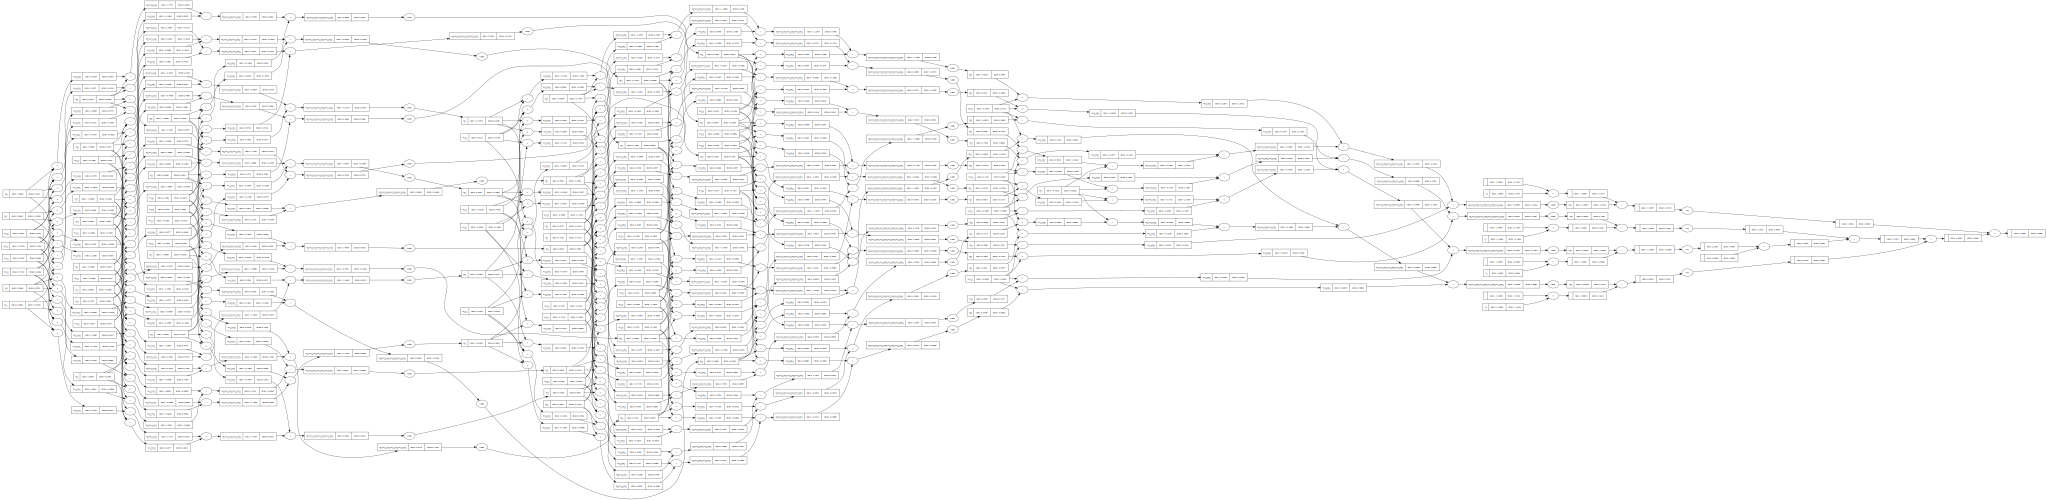

In [19]:
draw_dot(loss)

In [32]:
for p in T.parameters():
    p.data += -0.01 * p.grad

In [33]:
ypred = [T(x) for x in xs]
loss = sum(((yout-ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))
loss

Value(data=2.4960825535913793)

In [34]:
x = [2, 5, 6]
T(x)

Value(data=-0.6865880543292403)

In [18]:
for k in range(20):

    for p in T.parameters():
        p.grad = 0.0 #重置梯度，否则会累加
    ypred = [T(x) for x in xs]
    loss = sum(((yout-ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))
    #在对T的参数梯度重置后，无需再对loss进行梯度重置，循环变量
    #ygt，yout的grad继承ys和ypred，而且不会累加，ys是常量0梯度，ypred继承T参数梯度
    #另外，被减的ygt是ys常量，画图过程中不会产生多余节点，如果反过来会吗？（在测试案例中会的）
    #常量相加无论正负默认都是按照__add__来处理的
    loss.backward()
    
    for p in T.parameters():
        p.data += -0.05 * p.grad

    print(k,loss.data)

0 7.337652739936232
1 6.870856775430881
2 5.592047314210389
3 2.4241065340212504
4 0.5888624027662956
5 0.29857582122119564
6 0.20483552406589792
7 0.1567668853310229
8 0.12705922561575902
9 0.10681613688067339
10 0.0921231433068968
11 0.08096956711845213
12 0.07221306083148049
13 0.06515566079417
14 0.05934658978357741
15 0.05448163999395535
16 0.05034804656001868
17 0.04679251662224211
18 0.04370180143561299
19 0.04099041988515794


In [11]:
ypred

[Value(data=0.8695826610435867),
 Value(data=-0.9131688703665697),
 Value(data=-0.8075016800715),
 Value(data=0.8072574547026777)]

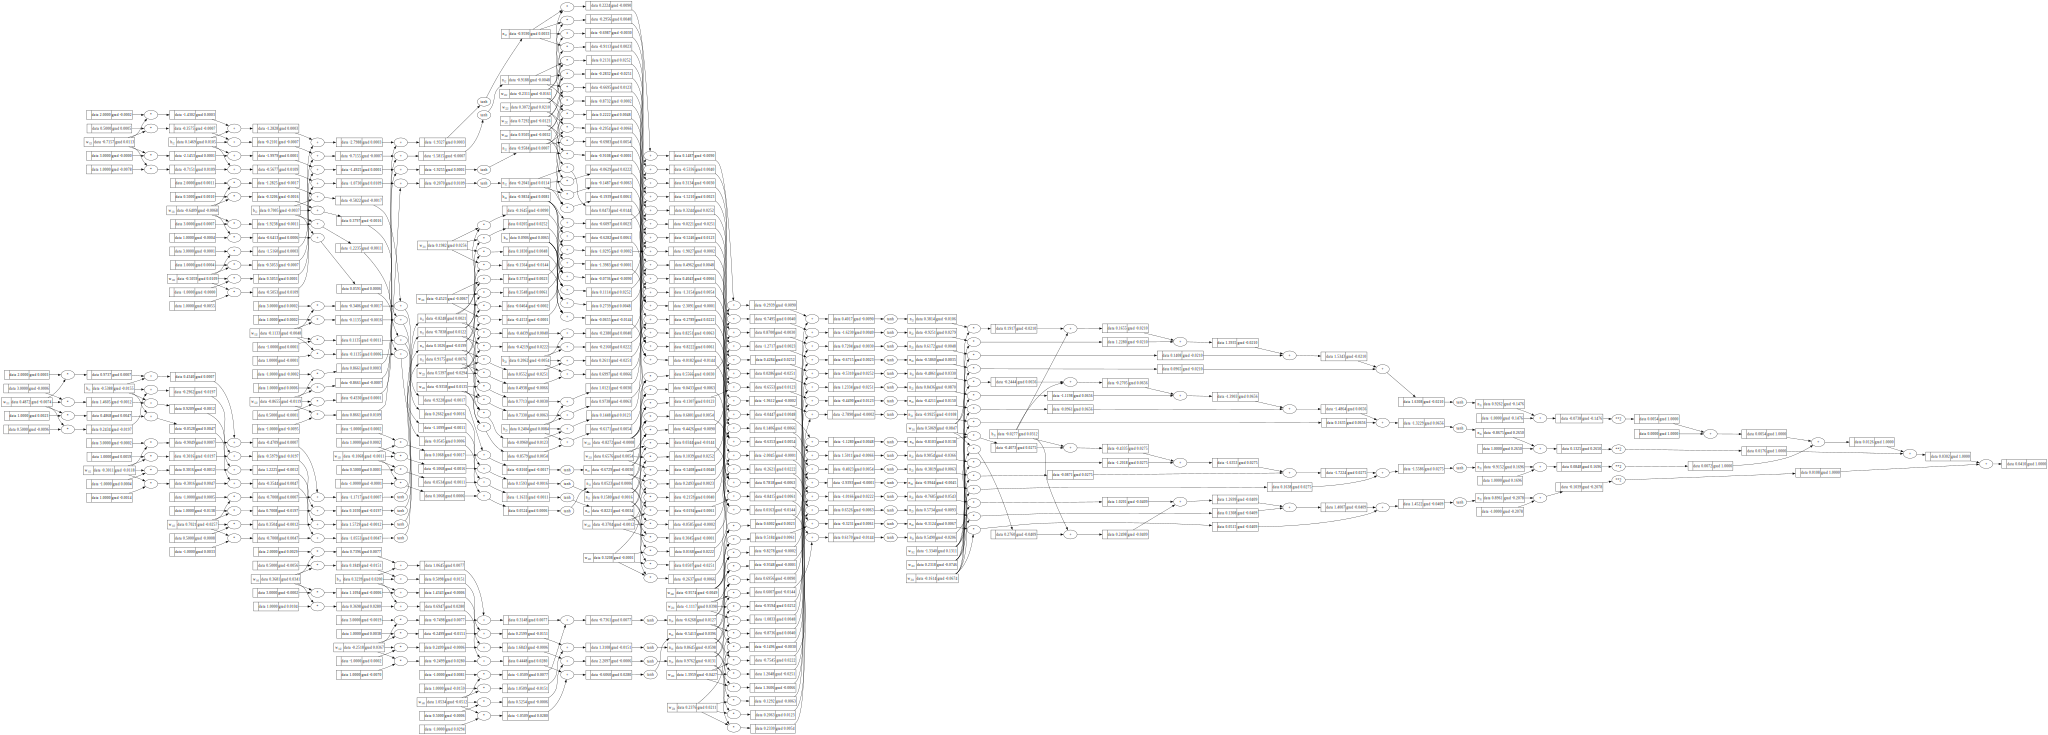

In [19]:
draw_dot(loss)